<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [2]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2018-08-13 

CPython 2.7.13
IPython 5.7.0

numpy 1.14.5
matplotlib 2.2.2
scipy 1.1.0
pandas 0.23.1
sklearn 0.19.1
mlxtend 0.12.0


# Laputop reconstruction performance
### Table of contents
1. [Load simulation DataFrame and apply quality cuts](#Load-simulation-DataFrame-and-apply-quality-cuts)
2. [Define functions to be fit to effective area](#Define-functions-to-be-fit-to-effective-area)
3. [Calculate effective areas](#Calculate-effective-areas)
4. [Plot result](#Plot-result)

In [3]:
from __future__ import division, print_function
import os
from collections import defaultdict
import numpy as np
from scipy import optimize
from scipy.stats import chisquare
from scipy.stats import binned_statistic
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from icecube import phys_services

import comptools as comp

sns.set_context(context='paper', font_scale=1.5)
color_dict = comp.get_color_dict()

%matplotlib inline

## Load simulation DataFrame and apply quality cuts
[ [back to top](#top) ]

In [4]:
config = 'IC86.2012'
num_groups = 2

comp_list = comp.get_comp_list(num_groups=num_groups)
energybins = comp.get_energybins(config)
num_ebins = len(energybins.log_energy_midpoints)

In [5]:
df_sim = comp.load_sim(config=config,
                       energy_reco=False,
                       log_energy_min=None,
                       log_energy_max=None,
                       test_size=0,
                       n_jobs=10,
                       verbose=True)

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


[########################################] | 100% Completed | 21.4s
[########################################] | 100% Completed |  0.1s


In [7]:
MC_comp_mask = {}
for composition in comp_list:
    MC_comp_mask[composition] = df_sim['comp_group_{}'.format(num_groups)] == composition

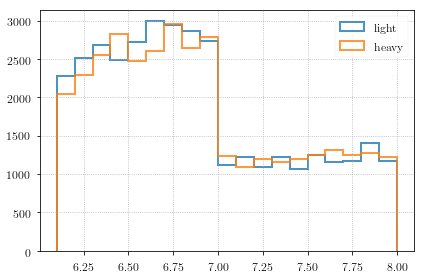

In [12]:
fig, ax = plt.subplots()

for composition in comp_list:
    comp_mask = MC_comp_mask[composition]
    ax.hist(df_sim.loc[comp_mask, 'MC_log_energy'],
            bins=energybins.log_energy_bins,
            histtype='step',
            color=color_dict[composition],
            lw=2,
            alpha=0.8,
            label=composition)
ax.grid()
ax.legend()
plt.show()

## Angular resolution
[ [back to top](#top) ]

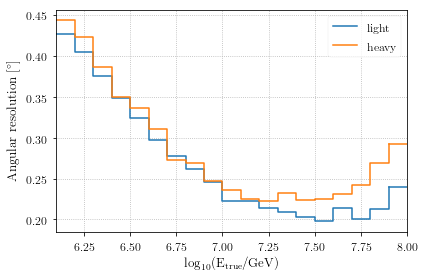

In [41]:
fig, ax = plt.subplots()
for composition in comp_list:
    comp_mask = MC_comp_mask[composition]
    null_mask = df_sim.loc[comp_mask, 'angle_MCPrimary_Laputop'].isnull()
    ang_diff_deg = np.rad2deg(df_sim.loc[comp_mask, 'angle_MCPrimary_Laputop'].dropna())
    energy = df_sim.loc[comp_mask, 'MC_energy'].dropna()

    angular_res = comp.data_functions.get_resolution(energy, ang_diff_deg, energybins.energy_bins)
    
    comp.plot_steps(energybins.log_energy_bins, angular_res,
                    lw=1.5,
                    color=color_dict[composition],
                    label=composition,
                    ax=ax)

# ax.set_ylim([0.0, 0.4])
# ax.set_xlim(6.4, 8)
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('Angular resolution [$^{\circ}$]')
ax.grid()
ax.legend()

angular_res_outfile = os.path.join(comp.paths.figures_dir,
                                   'laputop_performance',
                                   'angular_res_CR_group_{}.png'.format(config))
comp.check_output_dir(angular_res_outfile)
plt.savefig(angular_res_outfile)

plt.show()

## Core resolution
[ [back to top](#top) ]

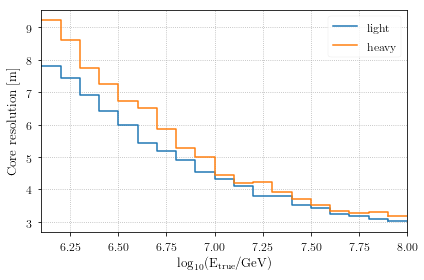

In [44]:
fig, ax = plt.subplots()
for composition in comp_list:
    comp_mask = MC_comp_mask[composition]
    dx = df_sim.loc[comp_mask, 'lap_x'] - df_sim.loc[comp_mask, 'MC_x']
    dy = df_sim.loc[comp_mask, 'lap_y'] - df_sim.loc[comp_mask, 'MC_y']
    core_diff = np.sqrt(dx ** 2 + dy ** 2)
    energy = df_sim.loc[comp_mask, 'MC_energy']
    core_res = comp.data_functions.get_resolution(energy, core_diff, energybins.energy_bins)
    comp.plot_steps(energybins.log_energy_bins, core_res,
                    lw=1.5,
                    color=color_dict[composition],
                    label=composition,
                    ax=ax)
    
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('Core resolution [m]')
ax.grid()
ax.legend()

core_res_outfile = os.path.join(comp.paths.figures_dir,
                                'laputop_performance',
                                'core_res_CR_group_{}.png'.format(config))
comp.check_output_dir(core_res_outfile)
plt.savefig(core_res_outfile)

plt.show()

## Appendix: Angular resolution calculation
[ [back to top](#top) ]

In [49]:
angle_bins = np.linspace(0, 3, 100)
angle_bin_midpoints = (angle_bins[1:] + angle_bins[:-1]) / 2
opening_angle_counts = {}
for composition in comp_list:
    comp_mask = MC_comp_mask[composition]
    opening_angle_counts[composition], _ = np.histogram(np.rad2deg(df_sim.loc[comp_mask, 'angle_MCPrimary_Laputop']),
                                                        bins=angle_bins)

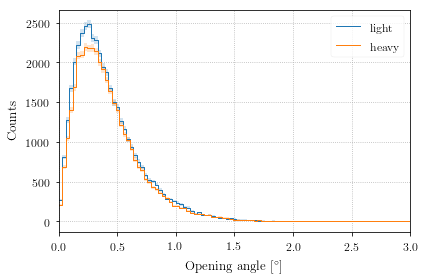

In [51]:
fig, ax = plt.subplots()
for composition in comp_list:
    comp.plot_steps(angle_bins, opening_angle_counts[composition],
                    yerr=np.sqrt(opening_angle_counts[composition]),
                    color=color_dict[composition],
                    label=composition,
                    ax=ax)

ax.set_xlim([0, 3])
ax.set_xlabel('Opening angle [$^{\circ}$]')
ax.set_ylabel('Counts')
ax.grid()
ax.legend()
plt.show()

In [54]:
cumulative_prob = {}
angle_sigma = {}
for composition in comp_list:
    cumulative_prob[composition] = np.cumsum(opening_angle_counts[composition])/opening_angle_counts[composition].sum()
    sigma_index = np.where(cumulative_prob[composition] < 0.68)[0].max()
    angle_sigma[composition] = angle_bin_midpoints[sigma_index] / 1.51

In [55]:
angle_sigma

{'heavy': 0.3110575958258078, 'light': 0.290989363837046}

## $\mathrm{S_{125}}$ reconstruction 

In [56]:
energy_mask = df_sim['MC_log_energy'] >= 6.4

In [75]:
corr = np.corrcoef(df_sim.loc[:, 'log_s125'].values, df_sim.loc[:, 'MC_log_energy'].values)
correlation = np.unique(corr)[0]
correlation

0.9904431588739184

In [57]:
h, xedges, yedges = np.histogram2d(df_sim.loc[:, 'log_s125'].values,
                                   df_sim.loc[:, 'MC_log_energy'].values,
#                                    bins=[log_125_bins, log_MC_energy_bins])
                                   bins=(50, 50))

In [58]:
h = h / h.sum(axis=0)

In [59]:
h.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [60]:
h = np.rot90(h)
h = np.flipud(h)
h = np.ma.masked_where(h == 0, h)

In [61]:
import matplotlib.colors as colors

In [62]:
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
extent

[-0.7863706656992693, 2.1775389075026235, 5.316134256754441, 7.999821416140386]

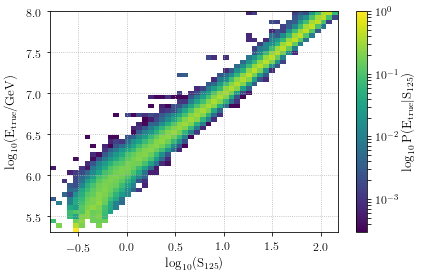

In [82]:
fig, ax = plt.subplots()
im = ax.imshow(h,
               extent=extent,
               origin='lower',
               interpolation='none',
               cmap='viridis',
               aspect='auto',
               norm=colors.LogNorm(),
              )
plt.colorbar(im, label='$\mathrm{\log_{10} P(E_{true} | S_{125})}$')

ax.set_ylabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_xlabel('$\mathrm{\log_{10}(S_{125})}$')
# ax.set_ylim(energybins.log_energy_min, energybins.log_energy_max)

# ax.annotate('{:0.3f}'.format(correlation), (1.0, 6.0))

ax.grid()

outfile = os.path.join(comp.paths.figures_dir, 'laputop_performance', 's125_vs_MC_energy.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

In [ ]:
df_sim.angle_MCPrimary_Laputop

In [3]:
df_sim, cut_dict_sim = comp.load_dataframe(datatype='sim', config='IC79', return_cut_dict=True)
selection_mask = np.array([True] * len(df_sim))
standard_cut_keys = ['IceTopQualityCuts', 'lap_InIce_containment',
                'num_hits_1_60', 'max_qfrac_1_60']
#                 'InIceQualityCuts']
for cut in ['MilliNCascAbove2', 'MilliQtotRatio', 'MilliRloglBelow2', 'StochRecoSucceeded']:
    standard_cut_keys += ['InIceQualityCuts_{}'.format(cut)]
    
for key in standard_cut_keys:
    selection_mask *= cut_dict_sim[key]
    print(key, np.sum(selection_mask))

df_sim = df_sim[selection_mask]

Returning without applying quality cuts


/home/jbourbeau/cr-composition/composition/dataframe_functions.py:139: RuntimeWarning: divide by zero encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])
/home/jbourbeau/cr-composition/composition/dataframe_functions.py:139: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])
/home/jbourbeau/cr-composition/composition/dataframe_functions.py:140: RuntimeWarning: divide by zero encountered in log10
  df['log_dEdX_standard'] = np.log10(df['eloss_1500_standard'])
/home/jbourbeau/cr-composition/composition/dataframe_functions.py:140: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX_standard'] = np.log10(df['eloss_1500_standard'])
/home/jbourbeau/cr-composition/composition/dataframe_functions.py:141: RuntimeWarning: divide by zero encountered in log10
  df['log_dEdX_strong'] = np.log10(df['eloss_1500_strong'])
/home/jbourbeau/cr-composition/composition/dataframe_functions.py:141: RuntimeWarning: in

IceTopQualityCuts 398044
lap_InIce_containment 308917
num_hits_1_60 308874
max_qfrac_1_60 308830
InIceQualityCuts_MilliNCascAbove2 303668
InIceQualityCuts_MilliQtotRatio 298427
InIceQualityCuts_MilliRloglBelow2 298427
InIceQualityCuts_StochRecoSucceeded 298426


#### Define energy binning for this analysis

In [5]:
energybins = comp.get_energybins()

energybins.energy_midpoints
# energy_bins = 10**np.arange(5.0, 9.51, 0.15)
# energy_bins = 10**np.arange(5.0, 9.51, 0.1)
# energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2

# energy_min_fit, energy_max_fit = 5.8, 9.5
# midpoints_fitmask = (energy_midpoints >= 10**energy_min_fit) & (energy_midpoints <= 10**energy_max_fit)

array([  2818382.93126445,   3548133.89233575,   4466835.92150963,
         5623413.25190348,   7079457.84384136,   8912509.38133742,
        11220184.54301958,  14125375.44622747,  17782794.10038912,
        22387211.38568324,  28183829.31264432,  35481338.92335724,
        44668359.21509589,  56234132.51903433,  70794578.43841301,
        89125093.81337404])

In [5]:
np.log10(energy_bins)

NameError: name 'energy_bins' is not defined

In [ ]:
np.log10(energy_midpoints[midpoints_fitmask])

In [5]:
comp_list = ['light', 'heavy']
MC_comp_mask = {}
for composition in comp_list:
    MC_comp_mask[composition] = df_sim['MC_comp_class'] == composition
light_mask = df_sim['MC_comp_class'] == 'light'
heavy_mask = df_sim['MC_comp_class'] == 'heavy'

### Energy resolution

In [6]:
energybins = comp.analysis.get_energybins()

In [7]:
energy_res = np.log10(df_sim['lap_energy'] / df_sim['MC_energy'])
avg_light, std_light, bin_edges = comp.analysis.data_functions.get_avg_std(df_sim['MC_log_energy'][light_mask],
                                                                           energy_res[light_mask],
                                                                           energybins.log_energy_bins)
avg_heavy, std_heavy, bin_edges = comp.analysis.data_functions.get_avg_std(df_sim['MC_log_energy'][heavy_mask],
                                                                           energy_res[heavy_mask],
                                                                           energybins.log_energy_bins)
# _, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(df_sim['lap_log_energy'][light_mask],
#                                                                            energy_res[light_mask],
#                                                                            energybins.log_energy_bins)
# _, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(df_sim['lap_log_energy'][heavy_mask],
#                                                                            energy_res[heavy_mask],
#                                                                            energybins.log_energy_bins)

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


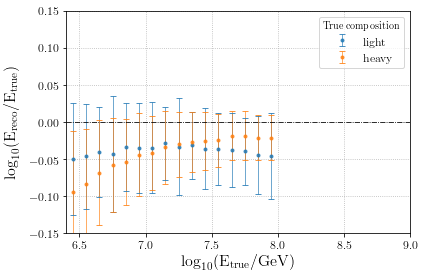

In [8]:
fig, ax = plt.subplots()
ax.errorbar(energybins.log_energy_midpoints, avg_light, yerr=std_light,
            marker='.', ls='None', label='light', alpha=0.8)
ax.errorbar(energybins.log_energy_midpoints, avg_heavy, yerr=std_heavy,
            marker='.', ls='None', label='heavy', alpha=0.8)
# ax.errorbar(energybins.log_energy_midpoints, bin_medians_light, yerr=error_light,
#             marker='.', ls='None', label='light', alpha=0.8)
# ax.errorbar(energybins.log_energy_midpoints, bin_medians_heavy, yerr=error_heavy,
#             marker='.', ls='None', label='heavy', alpha=0.8)
ax.axhline(0, marker='None', linestyle='-.', color='k')
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.set_xlim([6.4, 9.0])
ax.set_ylim([-0.15, 0.15])
ax.legend(title='True composition')
plt.grid()
# plt.savefig('/home/jbourbeau/public_html/figures/lap-energydist.png')
plt.show()

In [9]:
# zenith_mask = (np.cos(df_sim['MC_zenith']) > 0.95)
# zenith_mask = (np.cos(df_sim['MC_zenith']) < 0.9) & (np.cos(df_sim['MC_zenith']) > 0.8)
zenith_mask = np.array([True]*len(df_sim['MC_zenith']))

In [15]:
averages_light, standard_devs_light, _ = comp.analysis.get_avg_std(df_sim['MC_log_energy'][light_mask & zenith_mask],
                                                                   energy_res[light_mask & zenith_mask],
                                                                   energybins.log_energy_bins)
averages_heavy, standard_devs_heavy, _ = comp.analysis.get_avg_std(df_sim['MC_log_energy'][heavy_mask & zenith_mask],
                                                                   energy_res[heavy_mask & zenith_mask],
                                                                   energybins.log_energy_bins)

In [16]:
counts, bin_edges, bin_edges = binned_statistic(df_sim['lap_log_energy'][light_mask & zenith_mask],
                                               energy_res[light_mask & zenith_mask],
                                               bins = energybins.log_energy_bins, statistic='count')

In [17]:
counts

array([ 2478.,  2794.,  2791.,  2827.,  2728.,  2168.,  1242.,  1168.,
        1158.,  1209.,  1169.,  1201.,  1244.,  1245.,  1234.,   748.,
          20.,     0.,     0.,     0.,     0.])

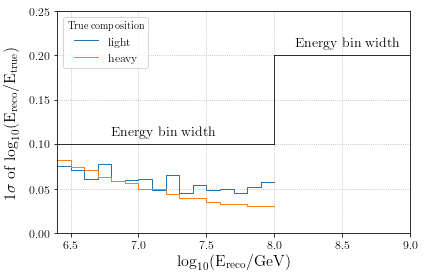

In [18]:
fig, ax = plt.subplots()
plotting.plot_steps(energybins.log_energy_bins, standard_devs_light, lw=1,
                    color=color_dict['light'], label='light', ax=ax)
plotting.plot_steps(energybins.log_energy_bins, standard_devs_heavy, lw=1,
                    color=color_dict['heavy'], label='heavy', ax=ax)
ax.axhline(0.1, 0, 0.6153846154, marker='None', color='k')
ax.axhline(0.2, 0.6153846154, 1, marker='None', color='k')
ax.axvline(8.0, (0.1)/(0.25), (0.2)/(0.25), marker='None', color='k')

ax.text(6.8, 0.11, 'Energy bin width', fontsize=14)
ax.text(8.15, 0.21, 'Energy bin width', fontsize=14)
ax.set_xlim([6.4, 9.0])
ax.set_ylim([0, 0.25])
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.grid()
ax.legend(title='True composition', loc='upper left')
# plt.savefig('/home/jbourbeau/public_html/figures/lap-energyres.png')
plt.show()

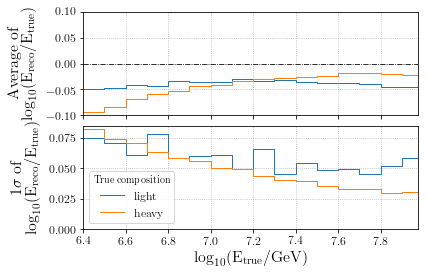

In [19]:
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

plotting.plot_steps(energybins.log_energy_bins, averages_light, lw=1,
                    color=color_dict['light'], label='light', ax=ax1)
plotting.plot_steps(energybins.log_energy_bins, averages_heavy, lw=1,
                    color=color_dict['heavy'], label='heavy', ax=ax1)
ax1.axhline(0, marker='None', linestyle='-.', color='k')
# ax1.set_ylabel('Energy bias \n$[\mathrm{\log_{10}(E/GeV)}$]')
ax1.set_ylabel('Average of \n$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax1.set_ylim(-0.1, 0.1)
ax1.tick_params(labelbottom='off')    
ax1.grid()

plotting.plot_steps(energybins.log_energy_bins, standard_devs_light, lw=1,
                    color=color_dict['light'], label='light', ax=ax2)
plotting.plot_steps(energybins.log_energy_bins, standard_devs_heavy, lw=1,
                    color=color_dict['heavy'], label='heavy', ax=ax2)

# ax2.set_ylabel('Energy resolution \n$[\mathrm{\log_{10}(E/GeV)}$]')
ax2.set_ylabel('1$\mathrm{\sigma}$ of \n$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax2.set_ylim(0)
ax2.set_xlim(energybins.log_energy_bins.min())
ax2.grid()
ax2.legend(title='True composition')

plt.show()

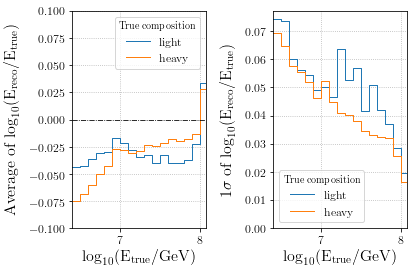

In [73]:
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.5)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)

plotting.plot_steps(energybins.log_energy_bins, averages_light, lw=1,
                    color=color_dict['light'], label='light', ax=ax1)
plotting.plot_steps(energybins.log_energy_bins, averages_heavy, lw=1,
                    color=color_dict['heavy'], label='heavy', ax=ax1)
ax1.axhline(0, marker='None', linestyle='-.', color='k')
ax1.set_ylabel('Average of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
# ax1.set_ylabel('$\mathrm{\langle \log_{10}(E_{reco}/E_{true}) \\rangle}$')
ax1.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax1.set_ylim(-0.1, 0.1)
# ax1.tick_params(labelbottom='off')    
ax1.grid()
ax1.legend(title='True composition')

plotting.plot_steps(energybins.log_energy_bins, standard_devs_light, lw=1,
                    color=color_dict['light'], label='light', ax=ax2)
plotting.plot_steps(energybins.log_energy_bins, standard_devs_heavy, lw=1,
                    color=color_dict['heavy'], label='heavy', ax=ax2)

# ax2.set_ylabel('Energy resolution \n$[\mathrm{\log_{10}(E/GeV)}$]')
ax2.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax2.set_ylim(0)
ax2.set_xlim(energybins.log_energy_bins.min())
ax2.grid()
ax2.legend(title='True composition')

plt.show()

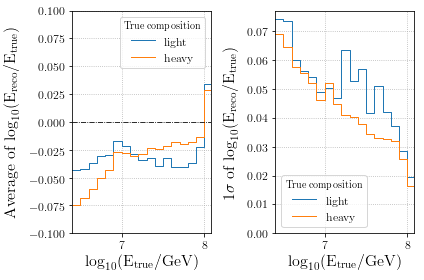

In [65]:
fig, axarr = plt.subplots(1, 2, sharex=True)
ax1, ax2 = axarr
plotting.plot_steps(energybins.log_energy_bins, averages_light, lw=1,
                    color=color_dict['light'], label='light', ax=ax1)
plotting.plot_steps(energybins.log_energy_bins, averages_heavy, lw=1,
                    color=color_dict['heavy'], label='heavy', ax=ax1)
ax1.axhline(0, marker='None', linestyle='-.', color='k')
# ax1.set_ylabel('Energy bias \n$[\mathrm{\log_{10}(E/GeV)}$]')
ax1.set_ylabel('Average of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax1.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax1.set_ylim(-0.1, 0.1)
# ax1.tick_params(labelbottom='off')    
ax1.grid()
ax1.legend(title='True composition')

plotting.plot_steps(energybins.log_energy_bins, standard_devs_light, lw=1,
                    color=color_dict['light'], label='light', ax=ax2)
plotting.plot_steps(energybins.log_energy_bins, standard_devs_heavy, lw=1,
                    color=color_dict['heavy'], label='heavy', ax=ax2)

# ax2.set_ylabel('Energy resolution \n$[\mathrm{\log_{10}(E/GeV)}$]')
ax2.set_ylabel('1$\mathrm{\sigma}$ of $\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax2.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax2.set_ylim(0)
ax2.set_xlim(energybins.log_energy_bins.min())
ax2.grid()
ax2.legend(title='True composition')

plt.show()

## Angular resolution

In [39]:
df_sim['angle_MC_Laputop'].dropna()

0          0.009606
1          0.005077
2          0.004590
3          0.069018
4          0.005256
5          0.009519
6          0.011146
7          0.005687
8          0.010367
9          0.009933
10         0.002887
11         0.021184
12         0.002821
13         0.001822
14         0.008231
15         0.006985
16         0.006534
17         0.099332
18         0.026003
19         0.002510
20         0.063744
21         0.012882
22         0.043114
23         0.645495
24         0.001410
25         0.019312
26         0.002687
27         0.006179
28         0.191317
29         0.039024
             ...   
4137514    0.090083
4137515    0.009260
4137516    0.003806
4137518    0.038567
4137519    0.319203
4137520    0.006746
4137521    0.046584
4137522    0.008038
4137523    0.007408
4137524    0.020099
4137525    0.024636
4137526    0.162863
4137527    0.036386
4137528    0.016773
4137529    0.054414
4137530    0.455335
4137531    0.011189
4137532    0.056233
4137533    0.041077


In [96]:
cumulative_prob = {}
angle_sigma = {}
for composition in comp_list:
    cumulative_prob[composition] = np.cumsum(opening_angle_counts[composition])/opening_angle_counts[composition].sum()
    sigma_index = np.where(cumulative_prob[composition] < 0.68)[0].max()
    angle_sigma[composition] = angle_bin_midpoints[sigma_index]

TypeError: get_resolution() takes exactly 3 arguments (1 given)

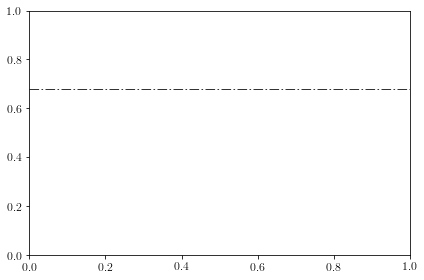

In [97]:
fig, ax = plt.subplots()
angle_bin_midpoints = (angle_bins[1:] + angle_bins[:-1]) / 2
for composition in comp_list:
    ax.axhline(0.68, marker='None', ls='-.', color='k')
    sigma = comp.analysis.get_resolution(df_sim[MC_comp_mask[composition]]['angle_MC_Laputop']*180/np.pi)*1.51
    ax.axvline(sigma, marker='None', ls='-.', color=color_dict[composition])
#     ax.axvline(angle_sigma[composition], marker='None', ls='-.', color=color_dict[composition])
    ax.plot(angle_bin_midpoints, cumulative_prob[composition], label=composition, marker='None', lw=2)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('Opening angle [deg]')
ax.set_ylabel('Cumulative probability')
ax.grid()
ax.legend()
plt.show()

(2051682,)
(1760690,)
(1987128,)
(1705633,)


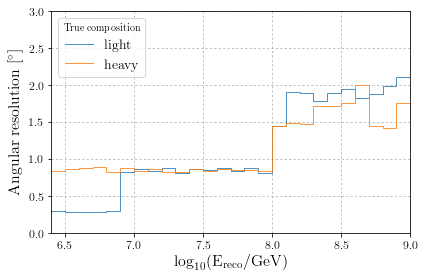

In [41]:
fig, ax = plt.subplots()
for composition in comp_list:
    null_mask = df_sim[MC_comp_mask[composition]]['angle_MC_Laputop'].isnull()
    ang_diff_deg = df_sim[MC_comp_mask[composition]]['angle_MC_Laputop'].dropna()*180/np.pi
    energy = df_sim[MC_comp_mask[composition]]['lap_energy'].dropna()
    print(ang_diff_deg.shape)
    print(energy.shape)
    angular_res = comp.analysis.get_resolution(energy, ang_diff_deg, energy_bins)
    plotting.plot_steps(np.log10(energy_bins), angular_res, lw=1,
                        color=color_dict[composition], label=composition, ax=ax)
ax.set_ylim([0.0, 3])
# ax.set_ylim([0.0, 0.6])
ax.set_xlim([6.4, 9.0])
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('Angular resolution [$^{\circ}$]')
ax.grid()
ax.legend(title='True composition', loc='upper left')
plt.savefig('/home/jbourbeau/public_html/figures/lap-angres-noqualitycuts.png')
plt.show()

### Core resolution

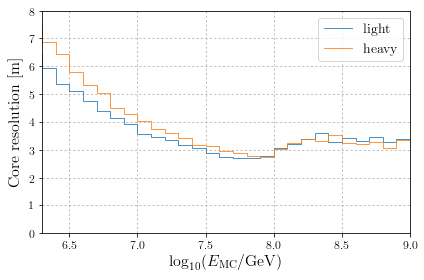

In [12]:
fig, ax = plt.subplots()
for composition in comp_list:
    core_diff = np.sqrt((df_sim[MC_comp_mask[composition]]['lap_x'] - df_sim[MC_comp_mask[composition]]['MC_x'])**2 \
                        +(df_sim[MC_comp_mask[composition]]['lap_y'] - df_sim[MC_comp_mask[composition]]['MC_y'])**2)
    energy = df_sim[MC_comp_mask[composition]]['MC_energy']
    core_res = comp.analysis.get_resolution(energy, core_diff, energy_bins)
    plotting.plot_steps(np.log10(energy_bins), core_res, lw=1,
                        color=color_dict[composition], label=composition, ax=ax)
ax.set_ylim([0.0, 8.0])
ax.set_xlim([6.3, 9.0])
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('Core resolution [m]')
ax.grid()
ax.legend()
plt.savefig('/home/jbourbeau/public_html/figures/lap-coreres.png')
plt.show()

In [11]:
core_res = np.sqrt((df_sim['lap_x'] - df_sim['MC_x'])**2+(df_sim['lap_y'] - df_sim['MC_y'])**2)
_, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(df_sim['MC_log_energy'][light_mask],
                                                                           core_res[light_mask],
                                                                           energybins.log_energy_bins)
_, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(df_sim['MC_log_energy'][heavy_mask],
                                                                           core_res[heavy_mask],
                                                                           energybins.log_energy_bins)

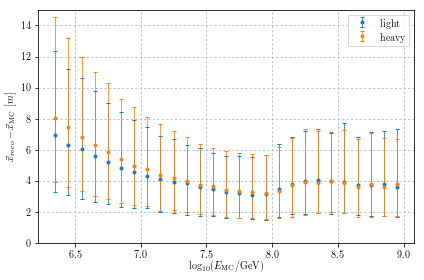

In [12]:
fig, ax = plt.subplots()
ax.errorbar(energybins.log_energy_midpoints, bin_medians_light, yerr=np.array(error_light),
            marker='.', ls='None', label='light')
ax.errorbar(energybins.log_energy_midpoints, bin_medians_heavy, yerr=np.array(error_heavy),
            marker='.', ls='None', label='heavy')
ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\\vec{x}_{\mathrm{reco}}-\\vec{x}_{\mathrm{MC}} \ [m]$')
ax.set_ylim([0, 15])
ax.legend()
# ax2 = ax.twinx()
# ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
# ax2.set_ylim(list(ax.get_ylim()))
# # ax2.axhline(0.1, marker='None', linestyle='-.', color='gray')
# # ax2.axhline(-0.1, marker='None', linestyle='-.', color='gray')
# plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
plt.grid()
plt.savefig('/home/jbourbeau/public_html/figures/lap-coreres.png')
plt.show()

### S125 resolution

In [4]:
energybins = comp.analysis.get_energybins()

In [7]:
log_s125 = df_sim['log_s125']
light_mask = df_sim['MC_comp_class'] == 'light'
heavy_mask = df_sim['MC_comp_class'] == 'heavy'
_, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(df_sim['MC_log_energy'][light_mask],
                                                                           log_s125[light_mask],
                                                                           energybins.log_energy_bins)
_, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(df_sim['MC_log_energy'][heavy_mask],
                                                                           log_s125[heavy_mask],
                                                                           energybins.log_energy_bins)

In [12]:
error_light

[array([ 0.09651557,  0.09221753,  0.07779037,  0.0811578 ,  0.07666542,
         0.07022107,  0.07482537,  0.07082953,  0.05845881,  0.06768697,
         0.05951789,  0.06205757,  0.05596208,  0.05910467,  0.06077413,
         0.05680258]),
 array([ 0.07732384,  0.0762383 ,  0.07306298,  0.07036967,  0.06276594,
         0.06110872,  0.06102024,  0.05890272,  0.05434108,  0.0580092 ,
         0.05713199,  0.0568114 ,  0.05412523,  0.05500826,  0.05158618,
         0.0497067 ])]

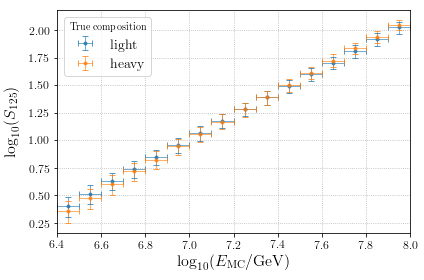

In [20]:
fig, ax = plt.subplots()
ax.errorbar(energybins.log_energy_midpoints, bin_medians_light, yerr=error_light, xerr=0.05, 
            marker='.', ls='None', label='light', color=color_dict['light'], alpha=0.75)
ax.errorbar(energybins.log_energy_midpoints, bin_medians_heavy, yerr=error_heavy, xerr=0.05, 
            marker='.', ls='None', label='heavy', color=color_dict['heavy'], alpha=0.75)
# plotting.plot_steps(energybins.log_energy_bins, bin_medians_light, yerr=error_light, ax=ax,
#                         color=color_dict['light'], label='light')
# plotting.plot_steps(energybins.log_energy_bins, bin_medians_heavy, yerr=error_heavy, ax=ax,
#                         color=color_dict['heavy'], label='heavy')
# ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\log_{10}(S_{\mathrm{125}})$')
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
# ax.set_ylim([-0.15, 0.15])
ax.legend(title='True composition')
# ax2 = ax.twinx()
# ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
# ax2.set_ylim(list(ax.get_ylim()))
# # ax2.axhline(0.1, marker='None', linestyle='-.', color='gray')
# # ax2.axhline(-0.1, marker='None', linestyle='-.', color='gray')
# plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
ax.grid()
plt.savefig('/home/jbourbeau/public_html/figures/lap-energyres.png')
plt.show()

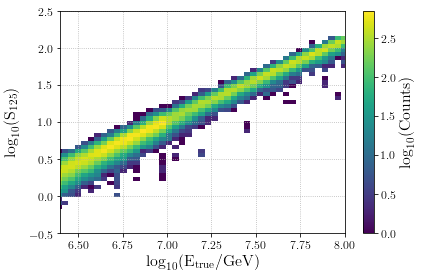

In [19]:
log_energy_bins = np.linspace(6.3, 9.0, 75)
log_s125_bins = np.linspace(-0.5, 3.5, 75)

fig, ax = plt.subplots()
plotting.histogram_2D(df_sim['MC_log_energy'], df_sim['log_s125'],
                      bins=(log_energy_bins, log_s125_bins), log_counts=True, ax=ax)
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(S_{125})}$')
# ax.set_xlim([6.4, 9.0])
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_ylim([-0.5, 2.5])
ax.legend()
ax.grid()
plt.savefig('/home/jbourbeau/public_html/figures/s125-vs-energy.png')
plt.show()

In [60]:
h, xedges, yedges  = np.histogram2d(df_sim['MC_log_energy'], df_sim['log_s125'],
                                    bins=(log_energy_bins, log_s125_bins))

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

In [61]:
h = np.rot90(h)
h = np.flipud(h)
# h[h == 0]

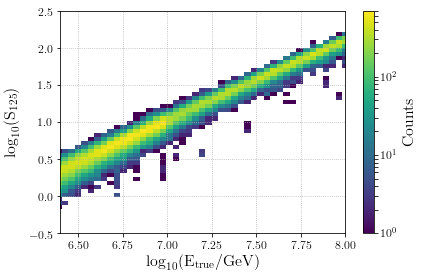

In [62]:
from matplotlib.colors import LogNorm

plt.imshow(h, extent=extent, norm=LogNorm(), origin='lower', interpolation='none', aspect='auto')
plt.xlim(energybins.log_energy_min, energybins.log_energy_max)
plt.ylim([-0.5, 2.5])
plt.xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
plt.ylabel('$\mathrm{\log_{10}(S_{125})}$')
plt.grid()
plt.colorbar(label='Counts')
plt.savefig('/home/jbourbeau/public_html/figures/s125-vs-energy.png')
plt.show()